<a href="https://colab.research.google.com/github/SunwungLee/reproduction/blob/master/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from torch import optim
import imgaug.augmenters as iaa
from torch import nn
from keras.utils import to_categorical


import matplotlib.pyplot as plt
import numpy as np

SET_MNIST, SET_CIFAR, SET_NORB = 0,1,2

In [0]:
def translate(X, x_mag_aug, y_mag_aug):
  result = iaa.Affine(translate_px={"x": (x_mag_aug, x_mag_aug), "y": (y_mag_aug, y_mag_aug)})
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

def crop(X, mg_aug):
  result = iaa.Crop(px=tuple((mg_aug, mg_aug) for i in range(4)),
                    sample_independently=True,
                    keep_size=True)
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

def rotate(X, mg_aug):
  result = iaa.Affine(rotate=(mg_aug, mg_aug))
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

In [0]:
def load_dataset(SET_):
	if SET_ == SET_CIFAR:
		(trainX, trainY), (testX, testY) = cifar10.load_data()
		classes=(0,1)

	elif SET_ == SET_MNIST:
		(trainX, trainY), (testX, testY) = MNIST.load_data()
		classes=(3,8)

	trainY = trainY.flatten()
	mask = np.zeros(len(trainY), dtype=np.bool)
	for c in classes:
		mask |= (trainY == c)
		trainX_sub = trainX[mask]
		trainY_sub = trainY
		trainY_sub[mask & (trainY == classes[0])] = 0
		trainY_sub[mask & (trainY == classes[1])] = 1
		trainY_sub = trainY_sub[mask]

	testY = testY.flatten()
	mask = np.zeros(len(testY), dtype=np.bool)
	for c in classes:
		mask |= (testY == c)
		testX_sub = testX[mask]
		testY_sub = testY
		testY_sub[mask & (testY == classes[0])] = 0
		testY_sub[mask & (testY == classes[1])] = 1
		testY_sub = testY_sub[mask]
	#print(trainY_sub)
	trainY_sub = to_categorical(trainY_sub)
	testY_sub = to_categorical(testY_sub)

	#print(trainY_sub)

	return trainX_sub, trainY_sub, testX_sub, testY_sub


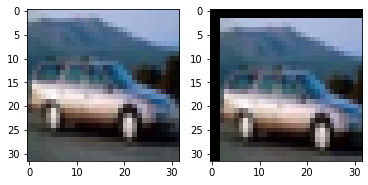

In [0]:
import matplotlib.pyplot as plt

trainX, trainY, testX, testY = load_dataset(SET_CIFAR)

f, ax = plt.subplots(1,2)

tmp = translate(trainX, 2,2)

ax[0].imshow(trainX[0])
ax[1].imshow(tmp[0])


In [0]:
import cifar10_resnet as resnet

input_shape = trainX.shape[1:]
print(input_shape)
model = None
model = resnet.resnet_v2(input_shape, 56, 2)
print(trainY.shape)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()
model.fit(trainX, trainY, validation_data=(testX, testY)) # original paper 128

(32, 32, 3)
(10000, 2)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_582 (Conv2D)             (None, 32, 32, 16)   448         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_551 (BatchN (None, 32, 32, 16)   64          conv2d_582[0][0]                 
__________________________________________________________________________________________________
activation_551 (Activation)     (None, 32, 32, 16)   0           batch_normalization_551[0][0]    
____________________________________________________________________

In [0]:
scores = model.evaluate(testX, testY)
print('Test loss; ', scores[0])
print('Test accuracy; ', scores[1])

2000/2000 [==============================] - 47s 24ms/step


In [0]:
import sklearn 
import sklearn.linear_model
import sklearn.pipeline

clf = sklearn.linear_model.LogisticRegression(max_iter=10000)

clf.fit(model.predict(trainX), trainY.argmax(1))
print("pass")
print(clf.score(model.predict(testX), testY.argmax(1)))

pass
0.88


In [0]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

loss = np.zeros(trainX.shape[0])
for i in range(trainX.shape[0]):
  loss[i] = sigmoid(np.dot(model.predict(trainX[i:i+1]), clf.coef_.T))

loss.shape

(10000,)

In [0]:
clf.coef_

array([[-6.22098822,  6.22101441]])